In [1]:
#Ideas
#Track down the incorrect predictions and see where they are in the distribition of the rest of the data
#Softmax function at the output layer?
#Make sure the weight initialization is random each time
#Can you somehow control the weight initialization to make sure its in a small range?

In [2]:
#HYPERPARAMETERS:
#-Activation function
#-Weight initialisation
#-Loss function
#-Training Algorithms
#-Training Algorithm parameters
#-Learning rate

In [3]:
#Previous Configurations

#Model 1
# model = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

# learning_rate = 0.01
# criterion = nn.MSELoss()
# # criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import random
import copy

In [5]:
with open('almonds_prep.pickle','rb') as file:
    All = pickle.load(file)

In [6]:
def myMSE(pred,true):
    return ((pred-true)**2).mean()

def convert(yout):
    y_out = copy.deepcopy(yout)
    for h in range(y_out.shape[0]):
        y_out[h][y_out[h] == y_out[h].max()] = 1
        y_out[h][y_out[h] != y_out[h].max()] = 0
    return y_out

def data_shuffler(X,Y,Y_binary):
    idxs = np.arange(0,len(X))
    random.shuffle(idxs)
    
    X_new = X[idxs]
    Y_new = Y[idxs]
    Y_binary_new = Y_binary[idxs]
    return X_new,Y_new,Y_binary_new

def batch_maker(X,Y,Y_binary,num_batches): #X,Y-> shuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/num_batches))
#     print(div)
    
    if num_batches == 1:
        return X,Y,Y_binary
    cnt1 = 0
    cnt2 = div
    Xbatch = []
    Ybatch = []
    Y_binary_batch = []
    for i in range(num_batches-1):
        
        Xbatch.append(X[cnt1:cnt2,:])
        Ybatch.append(Y[cnt1:cnt2])
        Y_binary_batch.append(Y_binary[cnt1:cnt2,:])

        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xbatch.append(X[cnt1:,:])
    Ybatch.append(Y[cnt1:])
    Y_binary_batch.append(Y_binary[cnt1:,:])

    return Xbatch,Ybatch,Y_binary_batch

def kfold_maker(X,Y,k): #X,Y-> unshuffled input and outputs
    tot = len(X)
    div = int(np.ceil(tot/k))
#     print(div)
    
    if k == 1:
        return X,Y
    cnt1 = 0
    cnt2 = div
    Xfolds = []
    Yfolds = []
    for i in range(k-1):
        
        Xfolds.append(X[cnt1:cnt2,:])
        Yfolds.append(Y[cnt1:cnt2,:])
        
        cnt1 = cnt2
        cnt2 = cnt1 + div
        
    Xfolds.append(X[cnt1:,:])
    Yfolds.append(Y[cnt1:,:])

    return Xfolds,Yfolds

def accuracy_calc(ytrain_pred, ytrain_target, ytest_pred, ytest_target):
    
    cnt_train = 0

    for h in range(len(ytrain_pred)):
        if sum(ytrain_pred[h,:] == ytrain_target[h,:]) < ytrain_target.shape[1]:
            cnt_train = cnt_train + 1
    incorr_pred_train = cnt_train

    cnt_test = 0
    for j in range(len(ytest_pred)):
        if sum(ytest_pred[j,:] == ytest_target[j,:]) < ytest_target.shape[1]:
            cnt_test = cnt_test + 1
    incorr_pred_test = cnt_test
    return incorr_pred_train, incorr_pred_test

In [7]:
class myNN(nn.Module):
    
    def __init__(self,n_input_features,n_output_features,n_layers_neurons):
        """
        n_input_features = Number of input features
        n_output_features = Number of output features
        n_layers_neurons = Dictionary of HIDDEN layer number and number of neurons in layer
           e.g.  3 hidden layers with 4, 2, and 7 neurons, respectively==> {1:4, 2: 2, 3: 7}
        
        """
        
        super().__init__()
        self.n_hidden_layers = len(list(n_layers_neurons)) #number of hidden layers
        #Creating all the layers
        
        self.layers = nn.ModuleList([nn.Linear(in_features = n_input_features, out_features = n_layers_neurons[1])])#First hidden layer
        
        for n in range(len(n_layers_neurons)-1):
            
            #All hidden layers
            self.layers.append(nn.Linear(in_features = n_layers_neurons[n+1], out_features = n_layers_neurons[n+2]))
            
        self.layers.append(nn.Linear(in_features = n_layers_neurons[list(n_layers_neurons)[-1]], out_features = n_output_features)) #Output layer

        
    def forward(self,x):
        
        #Hidden layers
        ys = []
        ys.append(nn.Tanh()(self.layers[0](x)))
#         print('First layer:',ys)
        for i in range(self.n_hidden_layers - 1):
#             print(i)
            net = self.layers[i+1](ys[i])
            ys.append(nn.Tanh()(net)) #Hidden layers
        
        net_output = self.layers[-1](ys[-1])
        output = nn. Softmax(dim=1)(net_output)
        return output,net_output

In [8]:
Xnum = np.vstack((All[0],All[1],All[2]))
print(Xnum.shape)

(2803, 13)


In [9]:
#Classes: 'MAMRA = [1,0,0]', 'SANORA = [0,1,0]', 'REGULAR' = [0,0,1]
Ynum = []
n_classes = 3
for n in range(len(Xnum)):
    if Xnum[n,-1] == "MAMRA":
        Ynum.append([1,0,0,0])
        
    elif Xnum[n,-1] == "SANORA":
        Ynum.append([0,1,0,1])
        
    elif Xnum[n,-1] == "REGULAR":
        Ynum.append([0,0,1,2])
        
    else:
        print(f"Error row index: {n}")

Xnum = Xnum[:,:-1]
Ynum = np.array(Ynum)
print(f"Input shape: {Xnum.shape}")
print(f"Output shape: {Ynum.shape}")

Input shape: (2803, 12)
Output shape: (2803, 4)


In [10]:
Xnum_train,Xnum_test,Ynum_train,Ynum_test = train_test_split(Xnum,Ynum,test_size = 0.3)
print("X train: ", Xnum_train.shape)
print("X test: ", Xnum_test.shape)
print("Y train: ", Ynum_train.shape)
print("Y test: ", Ynum_test.shape)
Y_binary_train_ = Ynum_train[:,0:-1]
Y_binary_test_ = Ynum_test[:,0:-1]

Ynum_train = Ynum_train[:,-1]
Ynum_test = Ynum_test[:,-1]

X train:  (1962, 12)
X test:  (841, 12)
Y train:  (1962, 4)
Y test:  (841, 4)


In [11]:
xdata_sc = StandardScaler()
Xnum_train = xdata_sc.fit_transform(Xnum_train)
Xnum_test = xdata_sc.transform(Xnum_test)

X_train_ = torch.tensor(Xnum_train.astype(np.float32))
Y_train_ = torch.tensor(Ynum_train,dtype=torch.long)
Y_binary_train_ = torch.tensor(Y_binary_train_.astype(np.float32))

X_test_ = torch.tensor(Xnum_test.astype(np.float32))
Y_test_ = torch.tensor(Ynum_test,dtype=torch.long)
Y_binary_test_ = torch.tensor(Y_binary_test_.astype(np.float32))

In [12]:
#=====SGD MODEL==============================

def mymodel_SGD(model_SGD,X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,learning_rate,momentum):    
    
#     model_SGD = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer = torch.optim.SGD(model_SGD.parameters(),lr = learning_rate,momentum = momentum)
    
    num_epochs = 0 #Keeps track of the number of epochs 
    losses_train = [] #Stores training losses at each epoch
    losses_test = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches the training dataset is divided into
    tol = 8e-3 #when the training should stop
    error = 100 
    max_epochs = 500
    
    while (error > tol) and (num_epochs < max_epochs):

        num_epochs += 1
#         print("==="*5,"Epoch",num_epochs,"==="*5)

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        for iteration in range(num_batches): #for each batch...
            

            if num_batches == 1:
                X_train_batch = Xbatches
                Y_train_batch = Ybatches
                Y_train_binary_batch = YBinaryBatches

            else:     

                X_train_batch = Xbatches[iteration]
                Y_train_batch = Ybatches[iteration]
                Y_train_binary_batch = YBinaryBatches[iteration]

            
            #Forward pass
            ypred_train,output_net = model_SGD(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

            #Compute loss
            loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

            #Backward pass
            loss_train.backward()
#             print(f"===== Batch no. {iteration + 1}=====")
#             print(f"\n Batch Pred: \n{ypred_train} \n Batch Target:\n {Y_train_binary_batch}")
#             print("\n Batch Training Loss: ",loss_train)

            #Update weights
            optimizer.step()
            optimizer.zero_grad()

        #At the end of each epoch...
        with torch.no_grad():

            #Forward pass using entire dataset
            ypred_train_epoch,output_net_train_epoch = model_SGD(X_train)
            ypred_test_epoch,output_net_test_epoch = model_SGD(X_test)

            loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
            losses_train.append(loss_train_epoch)

            loss_test_epoch = criterion(output_net_test_epoch,Y_test).sum()/(n_classes*len(Y_test))
            losses_test.append(loss_test_epoch)

            #Accuracy Calculation
            Ypred_train_epoch = convert(ypred_train_epoch)
            Ypred_test_epoch = convert(ypred_test_epoch)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
            error = ((ypred_train_epoch - Y_binary_train)**2).mean()

    losses_train = torch.tensor(losses_train)
    losses_test = torch.tensor(losses_test)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)
    
    return {"LossTrain":losses_train,
            "LossTest":losses_test,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs}

#=====ADAM MODEL==============================

def mymodel_Adam(model_Adam,X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,learning_rate):    
    
#     model_Adam = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer = torch.optim.Adam(model_Adam.parameters(),lr = learning_rate)
    
    num_epochs = 0 #Keeps track of the number of epochs 
    losses_train = [] #Stores training losses at each epoch
    losses_test = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches the training dataset is divided into
    tol = 8e-3 #when the training should stop
    error = 100 
    max_epochs = 500
    
    while (error > tol) and (num_epochs < max_epochs):

        num_epochs += 1

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        for iteration in range(num_batches): #for each batch...

            if num_batches == 1:
                X_train_batch = Xbatches
                Y_train_batch = Ybatches
                Y_train_binary_batch = YBinaryBatches

            else:     

                X_train_batch = Xbatches[iteration]
                Y_train_batch = Ybatches[iteration]
                Y_train_binary_batch = YBinaryBatches[iteration]

            
            #Forward pass
            ypred_train,output_net = model_Adam(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

            #Compute loss
            loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

            #Backward pass
            loss_train.backward()

            #Update weights
            optimizer.step()
            optimizer.zero_grad()

        #At the end of each epoch...
        with torch.no_grad():

            #Forward pass using entire dataset
            ypred_train_epoch,output_net_train_epoch = model_Adam(X_train)
            ypred_test_epoch,output_net_test_epoch = model_Adam(X_test)

            loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
            losses_train.append(loss_train_epoch)

            loss_test_epoch = criterion(output_net_test_epoch,Y_test).sum()/(n_classes*len(Y_test))
            losses_test.append(loss_test_epoch)

            #Accuracy Calculation
            Ypred_train_epoch = convert(ypred_train_epoch)
            Ypred_test_epoch = convert(ypred_test_epoch)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
            error = ((ypred_train_epoch - Y_binary_train)**2).mean()
                
    losses_train = torch.tensor(losses_train)
    losses_test = torch.tensor(losses_test)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)
    
    return {"LossTrain":losses_train,
            "LossTest":losses_test,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs}

#=====RPROP MODEL==============================

def mymodel_Rprop(model_Rprop,X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,nlow,nhigh):    
    
#     model_Rprop = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer = torch.optim.Rprop(model_Rprop.parameters(),etas=(nlow,nhigh))
    
    num_epochs = 0 #Keeps track of the number of epochs 
    losses_train = [] #Stores training losses at each epoch
    losses_test = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches the training dataset is divided into
    tol = 8e-3 #when the training should stop
    error = 100 
    max_epochs = 500
    
    while (error > tol) and (num_epochs < max_epochs):

        num_epochs += 1

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches,YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        for iteration in range(num_batches): #for each batch...

            if num_batches == 1:
                X_train_batch = Xbatches
                Y_train_batch = Ybatches
                Y_train_binary_batch = YBinaryBatches

            else:     

                X_train_batch = Xbatches[iteration]
                Y_train_batch = Ybatches[iteration]
                Y_train_binary_batch = YBinaryBatches[iteration]
            
            #Forward pass
            ypred_train,output_net = model_Rprop(X_train_batch) #net_ouput is the output before the activation function of the output layer. This goes into the loss function.

            #Compute loss
            loss_train = criterion(output_net,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

            #Backward pass
            loss_train.backward()

            #Update weights
            optimizer.step()
            optimizer.zero_grad()

        #At the end of each epoch...
        with torch.no_grad():

            #Forward pass using entire dataset
            ypred_train_epoch,output_net_train_epoch = model_Rprop(X_train)
            ypred_test_epoch,output_net_test_epoch = model_Rprop(X_test)

            loss_train_epoch = criterion(output_net_train_epoch,Y_train).sum()/(n_classes*len(Y_train))
            losses_train.append(loss_train_epoch)

            loss_test_epoch = criterion(output_net_test_epoch,Y_test).sum()/(n_classes*len(Y_test))
            losses_test.append(loss_test_epoch)

            #Accuracy Calculation
            Ypred_train_epoch = convert(ypred_train_epoch)
            Ypred_test_epoch = convert(ypred_test_epoch)

            cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
            accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
            accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
            error = ((ypred_train_epoch - Y_binary_train)**2).mean()
                
    losses_train = torch.tensor(losses_train)
    losses_test = torch.tensor(losses_test)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)
    
    return {"LossTrain":losses_train,
            "LossTest":losses_test,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs}

#=====HYBRID MODEL==============================
def hybrid_model(model_sgd,X_train_unshuff,X_test,Y_train_unshuff,Y_binary_train_unshuff,Y_test,Y_binary_test,lr_sgd,momentum,lr_adam,nlow,nhigh,weighting):
    
#     model_sgd = myNN(12,3,{1:20,2:20,3:15,4:10,5:5})
    model_adam = copy.deepcopy(model_sgd)
    model_rprop = copy.deepcopy(model_sgd)

    criterion = nn.CrossEntropyLoss(reduction = 'none')
    optimizer_sgd = torch.optim.SGD(model_sgd.parameters(),lr = lr_sgd,momentum = momentum)
    optimizer_adam = torch.optim.Adam(model_adam.parameters(),lr = lr_adam)
    optimizer_rprop = torch.optim.Rprop(model_rprop.parameters(),etas = (nlow,nhigh))

    losses_train_sgd = [] #Stores training losses at each epoch
    losses_test_sgd = [] #Stores testing losses at each epoch
    
    accuracy_train = []
    accuracy_test = []

    num_batches = 1 #Number of training batches

    sgd_step_store = []
    adam_step_store = []
    rprop_step_store = []
    avg_step_store = []


    max_num_epochs = 500
    num_epochs = 0
    error = 100
    tol = 8e-3

    while (error > tol) and (num_epochs < max_num_epochs):

        num_epochs+= 1

        X_train,Y_train,Y_binary_train = data_shuffler(X_train_unshuff,Y_train_unshuff,Y_binary_train_unshuff)
        Xbatches, Ybatches, YBinaryBatches = batch_maker(X_train,Y_train,Y_binary_train,num_batches)

        X_train_batch = Xbatches
        Y_train_batch = Ybatches
        Y_train_binary_batch = YBinaryBatches

        #Forward pass
        ypred_train_sgd,output_net_sgd = model_sgd(X_train_batch)
        ypred_train_adam,output_net_adam = model_adam(X_train_batch)
        ypred_train_rprop,output_net_rprop = model_rprop(X_train_batch)

        #Compute loss
        loss_train_sgd = criterion(output_net_sgd,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
        loss_train_adam = criterion(output_net_adam,Y_train_batch).sum()/(n_classes*len(Y_train_batch))
        loss_train_rprop = criterion(output_net_rprop,Y_train_batch).sum()/(n_classes*len(Y_train_batch))

        #Backward pass
        loss_train_sgd.backward()
        loss_train_adam.backward()
        loss_train_rprop.backward()

        #Hybrid Learning Implementation
        #Save the previous step
        wt_state_sgd = copy.deepcopy(model_sgd.state_dict())
        wt_state_adam = copy.deepcopy(model_adam.state_dict())
        wt_state_rprop = copy.deepcopy(model_rprop.state_dict())

        #Update weights
        optimizer_sgd.step()
        optimizer_adam.step()
        optimizer_rprop.step()

        #Save the current step
        wt1_state_sgd = copy.deepcopy(model_sgd.state_dict())
        wt1_state_adam = copy.deepcopy(model_adam.state_dict())
        wt1_state_rprop = copy.deepcopy(model_rprop.state_dict())

        sgd_step_store_net = []
        adam_step_store_net = []
        rprop_step_store_net = []
        avg_step_store_net = []

        for sgd_wt1,adam_wt1,rprop_wt1 in zip(model_sgd.named_parameters(),model_adam.named_parameters(),model_rprop.named_parameters()):

            #Compute weight update/ step size-->Current step minus previous step
            sgd_step = wt1_state_sgd[sgd_wt1[0]].clone().detach() - wt_state_sgd[sgd_wt1[0]].clone().detach()
            adam_step = wt1_state_adam[adam_wt1[0]].clone().detach() - wt_state_adam[adam_wt1[0]].clone().detach()
            rprop_step = wt1_state_rprop[rprop_wt1[0]] - wt_state_rprop[rprop_wt1[0]].clone().detach()

            sgd_step_store_net.append(sgd_step)
            adam_step_store_net.append(adam_step)
            rprop_step_store_net.append(rprop_step)

            #combine the step sizes
            avg_step = weighting[0]*sgd_step + weighting[1]*adam_step + weighting[2]*rprop_step

            wt_state_sgd[sgd_wt1[0]] += avg_step #add the average step to the old state

            wt_state_adam[adam_wt1[0]] += avg_step #add the average step to the old state

            wt_state_rprop[rprop_wt1[0]] += avg_step #add the average step to the old state

            model_sgd.load_state_dict(wt_state_sgd) #update
            model_adam.load_state_dict(wt_state_adam) #update
            model_rprop.load_state_dict(wt_state_rprop) #update
            
            avg_step_store_net.append(avg_step)

        sgd_step_store.append(sgd_step_store_net)
        adam_step_store.append(adam_step_store_net)
        rprop_step_store.append(rprop_step_store_net)
        avg_step_store.append(avg_step_store_net)

        optimizer_sgd.zero_grad()
        optimizer_adam.zero_grad()
        optimizer_rprop.zero_grad()

        with torch.no_grad():

        #Forward pass using entire dataset
            ypred_train_epoch_sgd,output_net_train_epoch_sgd = model_sgd(X_train)
            ypred_test_epoch_sgd,output_net_test_epoch_sgd = model_sgd(X_test)

            loss_train_epoch_sgd = criterion(output_net_train_epoch_sgd,Y_train).sum()/(n_classes*len(Y_train))
            losses_train_sgd.append(loss_train_epoch_sgd)

            loss_test_epoch_sgd = criterion(output_net_test_epoch_sgd,Y_test).sum()/(n_classes*len(Y_test))
            losses_test_sgd.append(loss_test_epoch_sgd)

        #Accuracy Calculation
        Ypred_train_epoch = convert(ypred_train_epoch_sgd)
        Ypred_test_epoch = convert(ypred_test_epoch_sgd)

        cnt_train,cnt_test = accuracy_calc(Ypred_train_epoch, Y_binary_train, Ypred_test_epoch, Y_binary_test)
        accuracy_train.append(100-(cnt_train/len(Ypred_train_epoch)*100))
        accuracy_test.append(100-(cnt_test/len(Ypred_test_epoch)*100))
            
        error = ((ypred_train_epoch_sgd - Y_binary_train)**2).mean()

    losses_train_sgd = torch.tensor(losses_train_sgd)
    losses_test_sgd = torch.tensor(losses_test_sgd)
    
    accuracy_train = torch.tensor(accuracy_train)
    accuracy_test = torch.tensor(accuracy_test)
    
    return {"LossTrain":losses_train_sgd,
            "LossTest":losses_test_sgd,
            "AccTrain":accuracy_train,
            "AccTest":accuracy_test,
           "NumEpochs": num_epochs,
           "SGDWeightUpdates":sgd_step_store,
           "AdamWeightUpdates":adam_step_store,
           "RproprWeightUpdates":rprop_step_store,
           "AvgWeightUpdates":avg_step_store}

In [13]:
num_runs = 30

results1 = []
results2 = []
results3 = []
results4 = []

weighting = torch.tensor([0.4250, 0.4250, 0.1500])

for u in range(num_runs):
    
    MODEL = myNN(12,3,{1:20,2:20,3:15,4:10,5:5}) #model for all models
    MODEL1 = copy.deepcopy(MODEL)
    MODEL2 = copy.deepcopy(MODEL)
    MODEL3 = copy.deepcopy(MODEL)
    MODEL4 = copy.deepcopy(MODEL)

    model1 = mymodel_SGD(MODEL1,X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 1.0,momentum = 0.5)
    print("Done SGD")
    model2 = mymodel_Adam(MODEL2,X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,learning_rate = 0.041)
    print("Done Adam")
    model3 = mymodel_Rprop(MODEL3,X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,nlow = 0.9, nhigh = 1.2)
    print("Done Rprop")
    model4 = hybrid_model(MODEL4,X_train_,X_test_,Y_train_,Y_binary_train_,Y_test_,Y_binary_test_,lr_sgd = 1.0,momentum = 0.5,lr_adam = 0.041,nlow = 0.9, nhigh = 1.2,weighting = weighting)
    print("Done Hybrid")
    # lr_sgd = 1.0,momentum = 0.5,lr_adam = 0.041,nlow = 0.9,nhigh = 1.2,

    print(u+1)
    
    results1.append(model1)
    results2.append(model2)
    results3.append(model3)
    results4.append(model4)

Done SGD
Done Adam
Done Rprop
Done Hybrid
1
Done SGD
Done Adam
Done Rprop
Done Hybrid
2
Done SGD
Done Adam
Done Rprop
Done Hybrid
3
Done SGD
Done Adam
Done Rprop
Done Hybrid
4
Done SGD
Done Adam
Done Rprop
Done Hybrid
5
Done SGD
Done Adam
Done Rprop
Done Hybrid
6
Done SGD
Done Adam
Done Rprop
Done Hybrid
7
Done SGD
Done Adam
Done Rprop
Done Hybrid
8
Done SGD
Done Adam
Done Rprop
Done Hybrid
9
Done SGD
Done Adam
Done Rprop
Done Hybrid
10
Done SGD
Done Adam
Done Rprop
Done Hybrid
11
Done SGD
Done Adam
Done Rprop
Done Hybrid
12
Done SGD
Done Adam
Done Rprop
Done Hybrid
13
Done SGD
Done Adam
Done Rprop
Done Hybrid
14
Done SGD
Done Adam
Done Rprop
Done Hybrid
15
Done SGD
Done Adam
Done Rprop
Done Hybrid
16
Done SGD
Done Adam
Done Rprop
Done Hybrid
17
Done SGD
Done Adam
Done Rprop
Done Hybrid
18
Done SGD
Done Adam
Done Rprop
Done Hybrid
19
Done SGD
Done Adam
Done Rprop
Done Hybrid
20
Done SGD
Done Adam
Done Rprop
Done Hybrid
21
Done SGD
Done Adam
Done Rprop
Done Hybrid
22
Done SGD
Done Adam


In [14]:
losses1_train = []
losses2_train = []
losses3_train = []
losses4_train = []

losses1_test = []
losses2_test = []
losses3_test = []
losses4_test = []

acc1_train = []
acc2_train = []
acc3_train = []
acc4_train = []

acc1_test = []
acc2_test = []
acc3_test = []
acc4_test = []


for u in range(num_runs):
    losses1_train.append(results1[u]["LossTrain"][-1])
    losses2_train.append(results2[u]["LossTrain"][-1])
    losses3_train.append(results3[u]["LossTrain"][-1])
    losses4_train.append(results4[u]["LossTrain"][-1])
    
    losses1_test.append(results1[u]["LossTest"][-1])
    losses2_test.append(results2[u]["LossTest"][-1])
    losses3_test.append(results3[u]["LossTest"][-1])
    losses4_test.append(results4[u]["LossTest"][-1])
    
    acc1_train.append(results1[u]["AccTrain"][-1])
    acc2_train.append(results2[u]["AccTrain"][-1])
    acc3_train.append(results3[u]["AccTrain"][-1])
    acc4_train.append(results4[u]["AccTrain"][-1])

    acc1_test.append(results1[u]["AccTest"][-1])
    acc2_test.append(results2[u]["AccTest"][-1])
    acc3_test.append(results3[u]["AccTest"][-1])
    acc4_test.append(results4[u]["AccTest"][-1])
    
avg_train_loss1 = torch.tensor(losses1_train).mean()
avg_train_loss2 = torch.tensor(losses2_train).mean()
avg_train_loss3 = torch.tensor(losses3_train).mean()
avg_train_loss4 = torch.tensor(losses4_train).mean()

avg_test_loss1 = torch.tensor(losses1_test).mean()
avg_test_loss2 = torch.tensor(losses2_test).mean()
avg_test_loss3 = torch.tensor(losses3_test).mean()
avg_test_loss4 = torch.tensor(losses4_test).mean()

avg_train_acc1 = torch.tensor(acc1_train).mean()
avg_train_acc2 = torch.tensor(acc2_train).mean()
avg_train_acc3 = torch.tensor(acc3_train).mean()
avg_train_acc4 = torch.tensor(acc4_train).mean()

avg_test_acc1 = torch.tensor(acc1_test).mean()
avg_test_acc2 = torch.tensor(acc2_test).mean()
avg_test_acc3 = torch.tensor(acc3_test).mean()
avg_test_acc4 = torch.tensor(acc4_test).mean()

std_train_loss1 =torch.sqrt(torch.var(torch.tensor(losses1_train)))
std_train_loss2 =torch.sqrt(torch.var(torch.tensor(losses2_train)))
std_train_loss3 =torch.sqrt(torch.var(torch.tensor(losses3_train)))
std_train_loss4 =torch.sqrt(torch.var(torch.tensor(losses4_train)))

std_test_loss1 =torch.sqrt(torch.var(torch.tensor(losses1_test)))
std_test_loss2 =torch.sqrt(torch.var(torch.tensor(losses2_test)))
std_test_loss3 =torch.sqrt(torch.var(torch.tensor(losses3_test)))
std_test_loss4 =torch.sqrt(torch.var(torch.tensor(losses4_test)))

std_train_acc1 =torch.sqrt(torch.var(torch.tensor(acc1_train)))
std_train_acc2 =torch.sqrt(torch.var(torch.tensor(acc2_train)))
std_train_acc3 =torch.sqrt(torch.var(torch.tensor(acc3_train)))
std_train_acc4 =torch.sqrt(torch.var(torch.tensor(acc4_train)))

std_test_acc1 =torch.sqrt(torch.var(torch.tensor(acc1_test)))
std_test_acc2 =torch.sqrt(torch.var(torch.tensor(acc2_test)))
std_test_acc3 =torch.sqrt(torch.var(torch.tensor(acc3_test)))
std_test_acc4 =torch.sqrt(torch.var(torch.tensor(acc4_test)))

In [58]:
print(std_test_acc1,std_test_acc2,std_test_acc3,std_test_acc4)

tensor(1.8814) tensor(0.4905) tensor(0.5848) tensor(0.5424)


In [ ]:
ax0[1,0].set_xlabel("Model")
ax0[1,0].set_ylabel("Accuracy [%]")
ax0[1,0].set_title("Testing Accuracy")
ax0[1,0].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[1,0].scatter([0.5],[avg_test_acc1],marker = '*',color='b',label = 'SGD Model Avg.')
ax0[1,0].scatter([1.5],[avg_test_acc2],marker = '*',color='r',label = 'Adam Model Avg.')
ax0[1,0].scatter([2.5],[avg_test_acc3],marker = '*',color='g',label = 'Rprop Model Avg.')
ax0[1,0].scatter([3.5],[avg_test_acc4],marker = '*',color='m',label = 'Hybrid Model Avg.')

ax0[1,0].fill_between(np.array([1,1]),[avg_test_acc1 - 1*std_test_acc1,avg_test_acc1 - 1*std_test_acc1],[avg_test_acc1 + 1*std_test_acc1,avg_test_acc1 + 1*std_test_acc1],alpha = 0.2)
ax0[1,0].fill_between(np.array([1,2]),[avg_test_acc2 - 1*std_test_acc2,avg_test_acc2 - 1*std_test_acc2],[avg_test_acc2 + 1*std_test_acc2,avg_test_acc2 + 1*std_test_acc2],alpha = 0.2)
ax0[1,0].fill_between(np.array([2,3]),[avg_test_acc3 - 1*std_test_acc3,avg_test_acc3 - 1*std_test_acc3],[avg_test_acc3 + 1*std_test_acc3,avg_test_acc3 + 1*std_test_acc3],alpha = 0.2)
ax0[1,0].fill_between(np.array([3,4]),[avg_test_acc4 - 1*std_test_acc4,avg_test_acc4 - 1*std_test_acc4],[avg_test_acc4 + 1*std_test_acc4,avg_test_acc4 + 1*std_test_acc4],alpha = 0.2)



ax0[1,1].set_xlabel("Model")
ax0[1,1].set_ylabel("CE Loss")
ax0[1,1].set_title("Testing Loss")
ax0[1,1].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[1,1].scatter([0.5],[avg_test_loss1],marker = '*',color='b',label = 'SGD Model Avg.')
ax0[1,1].scatter([1.5],[avg_test_loss2],marker = '*',color='r',label = 'Adam Model Avg.')
ax0[1,1].scatter([2.5],[avg_test_loss3],marker = '*',color='g',label = 'Rprop Model Avg.')
ax0[1,1].scatter([3.5],[avg_test_loss4],marker = '*',color='m',label = 'Hybrid Model Avg.')

ax0[1,1].fill_between(np.array([1,1]),[avg_test_loss1 - 1*std_test_loss1,avg_test_loss1 - 1*std_test_loss1],[avg_test_loss1 + 1*std_test_loss1,avg_test_loss1 + 1*std_test_loss1],alpha = 0.2)
ax0[1,1].fill_between(np.array([1,2]),[avg_test_loss2 - 1*std_test_loss2,avg_test_loss2 - 1*std_test_loss2],[avg_test_loss2 + 1*std_test_loss2,avg_test_loss2 + 1*std_test_loss2],alpha = 0.2)
ax0[1,1].fill_between(np.array([2,3]),[avg_test_loss3 - 1*std_test_loss3,avg_test_loss3 - 1*std_test_loss3],[avg_test_loss3 + 1*std_test_loss3,avg_test_loss3 + 1*std_test_loss3],alpha = 0.2)
ax0[1,1].fill_between(np.array([3,4]),[avg_test_loss4 - 1*std_test_loss4,avg_test_loss4 - 1*std_test_loss4],[avg_test_loss4 + 1*std_test_loss4,avg_test_loss4 + 1*std_test_loss4],alpha = 0.2)




<IPython.core.display.Javascript object>


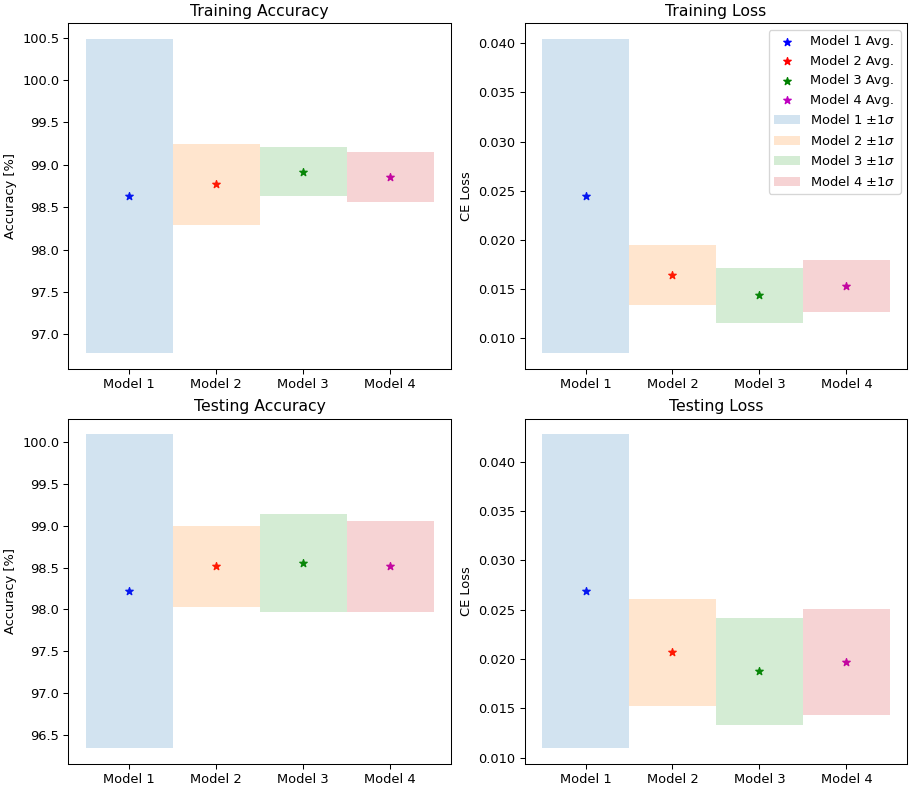

In [53]:
%matplotlib notebook
fig0, ax0 = plt.subplots(2,2,figsize = (9,9),layout = 'constrained')

ax0[0,0].set_ylabel("Accuracy [%]")
ax0[0,0].set_title("Training Accuracy")
ax0[0,0].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[0,0].scatter([0.5],[avg_train_acc1],marker = '*',color='b',label = 'Model 1 Avg.')
ax0[0,0].scatter([1.5],[avg_train_acc2],marker = '*',color='r',label = 'Model 2 Avg.')
ax0[0,0].scatter([2.5],[avg_train_acc3],marker = '*',color='g',label = 'Model 3 Avg.')
ax0[0,0].scatter([3.5],[avg_train_acc4],marker = '*',color='m',label = 'Model 4 Avg.')

ax0[0,0].fill_between(np.array([0,1]),[avg_train_acc1 - 1*std_train_acc1,avg_train_acc1 - 1*std_train_acc1],[avg_train_acc1 + 1*std_train_acc1,avg_train_acc1 + 1*std_train_acc1],alpha = 0.2,label = 'Model 1 $\pm 1 \sigma$')
ax0[0,0].fill_between(np.array([1,2]),[avg_train_acc2 - 1*std_train_acc2,avg_train_acc2 - 1*std_train_acc2],[avg_train_acc2 + 1*std_train_acc2,avg_train_acc2 + 1*std_train_acc2],alpha = 0.2,label = 'Model 2 $\pm 1 \sigma$')
ax0[0,0].fill_between(np.array([2,3]),[avg_train_acc3 - 1*std_train_acc3,avg_train_acc3 - 1*std_train_acc3],[avg_train_acc3 + 1*std_train_acc3,avg_train_acc3 + 1*std_train_acc3],alpha = 0.2,label = 'Model 3 $\pm 1 \sigma$')
ax0[0,0].fill_between(np.array([3,4]),[avg_train_acc4 - 1*std_train_acc4,avg_train_acc4 - 1*std_train_acc4],[avg_train_acc4 + 1*std_train_acc4,avg_train_acc4 + 1*std_train_acc4],alpha = 0.2,label = 'Model 4 $\pm 1 \sigma$')
# ax0[0,0].legend()

ax0[0,1].set_ylabel("CE Loss")
ax0[0,1].set_title("Training Loss")
ax0[0,1].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[0,1].scatter([0.5],[avg_train_loss1],marker = '*',color='b',label = 'Model 1 Avg.')
ax0[0,1].scatter([1.5],[avg_train_loss2],marker = '*',color='r',label = 'Model 2 Avg.')
ax0[0,1].scatter([2.5],[avg_train_loss3],marker = '*',color='g',label = 'Model 3 Avg.')
ax0[0,1].scatter([3.5],[avg_train_loss4],marker = '*',color='m',label = 'Model 4 Avg.')

ax0[0,1].fill_between(np.array([0,1]),[avg_train_loss1 - 1*std_train_loss1,avg_train_loss1 - 1*std_train_loss1],[avg_train_loss1 + 1*std_train_loss1,avg_train_loss1 + 1*std_train_loss1],alpha = 0.2,label = 'Model 1 $\pm 1 \sigma$')
ax0[0,1].fill_between(np.array([1,2]),[avg_train_loss2 - 1*std_train_loss2,avg_train_loss2 - 1*std_train_loss2],[avg_train_loss2 + 1*std_train_loss2,avg_train_loss2 + 1*std_train_loss2],alpha = 0.2,label = 'Model 2 $\pm 1 \sigma$')
ax0[0,1].fill_between(np.array([2,3]),[avg_train_loss3 - 1*std_train_loss3,avg_train_loss3 - 1*std_train_loss3],[avg_train_loss3 + 1*std_train_loss3,avg_train_loss3 + 1*std_train_loss3],alpha = 0.2,label = 'Model 3 $\pm 1 \sigma$')
ax0[0,1].fill_between(np.array([3,4]),[avg_train_loss4 - 1*std_train_loss4,avg_train_loss4 - 1*std_train_loss4],[avg_train_loss4 + 1*std_train_loss4,avg_train_loss4 + 1*std_train_loss4],alpha = 0.2,label = 'Model 4 $\pm 1 \sigma$')
ax0[0,1].legend()

#Testing
ax0[1,0].set_ylabel("Accuracy [%]")
ax0[1,0].set_title("Testing Accuracy")
ax0[1,0].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[1,0].scatter([0.5],[avg_test_acc1],marker = '*',color='b',label = 'SGD Model Avg.')
ax0[1,0].scatter([1.5],[avg_test_acc2],marker = '*',color='r',label = 'Adam Model Avg.')
ax0[1,0].scatter([2.5],[avg_test_acc3],marker = '*',color='g',label = 'Rprop Model Avg.')
ax0[1,0].scatter([3.5],[avg_test_acc4],marker = '*',color='m',label = 'Hybrid Model Avg.')

ax0[1,0].fill_between(np.array([0,1]),[avg_test_acc1 - 1*std_test_acc1,avg_test_acc1 - 1*std_test_acc1],[avg_test_acc1 + 1*std_test_acc1,avg_test_acc1 + 1*std_test_acc1],alpha = 0.2)
ax0[1,0].fill_between(np.array([1,2]),[avg_test_acc2 - 1*std_test_acc2,avg_test_acc2 - 1*std_test_acc2],[avg_test_acc2 + 1*std_test_acc2,avg_test_acc2 + 1*std_test_acc2],alpha = 0.2)
ax0[1,0].fill_between(np.array([2,3]),[avg_test_acc3 - 1*std_test_acc3,avg_test_acc3 - 1*std_test_acc3],[avg_test_acc3 + 1*std_test_acc3,avg_test_acc3 + 1*std_test_acc3],alpha = 0.2)
ax0[1,0].fill_between(np.array([3,4]),[avg_test_acc4 - 1*std_test_acc4,avg_test_acc4 - 1*std_test_acc4],[avg_test_acc4 + 1*std_test_acc4,avg_test_acc4 + 1*std_test_acc4],alpha = 0.2)

ax0[1,1].set_ylabel("CE Loss")
ax0[1,1].set_title("Testing Loss")
ax0[1,1].set_xticks([0.5,1.5,2.5,3.5],["Model 1","Model 2", "Model 3","Model 4"])
ax0[1,1].scatter([0.5],[avg_test_loss1],marker = '*',color='b',label = 'SGD Model Avg.')
ax0[1,1].scatter([1.5],[avg_test_loss2],marker = '*',color='r',label = 'Adam Model Avg.')
ax0[1,1].scatter([2.5],[avg_test_loss3],marker = '*',color='g',label = 'Rprop Model Avg.')
ax0[1,1].scatter([3.5],[avg_test_loss4],marker = '*',color='m',label = 'Hybrid Model Avg.')

ax0[1,1].fill_between(np.array([0,1]),[avg_test_loss1 - 1*std_test_loss1,avg_test_loss1 - 1*std_test_loss1],[avg_test_loss1 + 1*std_test_loss1,avg_test_loss1 + 1*std_test_loss1],alpha = 0.2)
ax0[1,1].fill_between(np.array([1,2]),[avg_test_loss2 - 1*std_test_loss2,avg_test_loss2 - 1*std_test_loss2],[avg_test_loss2 + 1*std_test_loss2,avg_test_loss2 + 1*std_test_loss2],alpha = 0.2)
ax0[1,1].fill_between(np.array([2,3]),[avg_test_loss3 - 1*std_test_loss3,avg_test_loss3 - 1*std_test_loss3],[avg_test_loss3 + 1*std_test_loss3,avg_test_loss3 + 1*std_test_loss3],alpha = 0.2)
ax0[1,1].fill_between(np.array([3,4]),[avg_test_loss4 - 1*std_test_loss4,avg_test_loss4 - 1*std_test_loss4],[avg_test_loss4 + 1*std_test_loss4,avg_test_loss4 + 1*std_test_loss4],alpha = 0.2)




# ax0[1,0].set_xlim([0,0.3])
# fig0.legend()

In [54]:
plt.savefig("Comparison_results",dpi = 200)

<IPython.core.display.Javascript object>


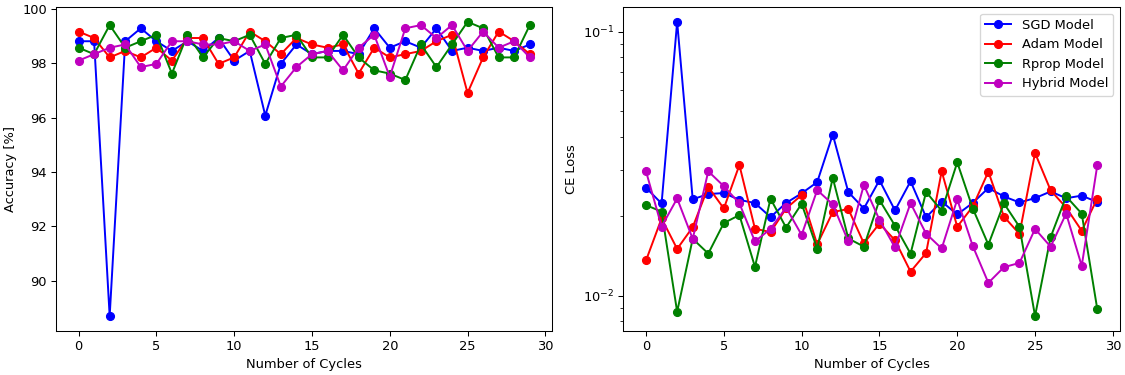

In [24]:
fig5, ax5 = plt.subplots(1,2,figsize = (12,4),layout = 'constrained')

ax5[0].plot(acc1_test,color='b',marker = 'o',label = "SGD Model")
ax5[0].plot(acc2_test,color='r',marker = 'o',label = "Adam Model")
ax5[0].plot(acc3_test,color='g',marker = 'o',label = "Rprop Model")
ax5[0].plot(acc4_test,color='m',marker = 'o',label = "Hybrid Model")

ax5[1].plot(losses1_test,color='b',marker = 'o',label = "SGD Model")
ax5[1].plot(losses2_test,color='r',marker = 'o',label = "Adam Model")
ax5[1].plot(losses3_test,color='g',marker = 'o',label = "Rprop Model")
ax5[1].plot(losses4_test,color='m',marker = 'o',label = "Hybrid Model")

ax5[0].set_xlabel("Number of Cycles")
ax5[1].set_xlabel("Number of Cycles")

ax5[0].set_ylabel("Accuracy [%]")
ax5[1].set_ylabel("CE Loss")
ax5[1].set_yscale('log')


# ax5[0].legend()
ax5[1].legend()

In [25]:
plt.savefig('AccLossComp',dpi = 200)

In [19]:
num_epoch_comp1 = []
num_epoch_comp2 = []
num_epoch_comp3 = []
num_epoch_comp4 = []


for i in range(0,num_runs):
    num_epoch_comp1.append(results1[i]["NumEpochs"])
    num_epoch_comp2.append(results2[i]["NumEpochs"])
    num_epoch_comp3.append(results3[i]["NumEpochs"])
    num_epoch_comp4.append(results4[i]["NumEpochs"])

In [66]:
epoch_std1 = np.sqrt(np.var(np.array(num_epoch_comp1)))
epoch_std2 = np.sqrt(np.var(np.array(num_epoch_comp2)))
epoch_std3 = np.sqrt(np.var(np.array(num_epoch_comp3)))
epoch_std4 = np.sqrt(np.var(np.array(num_epoch_comp4)))

<IPython.core.display.Javascript object>


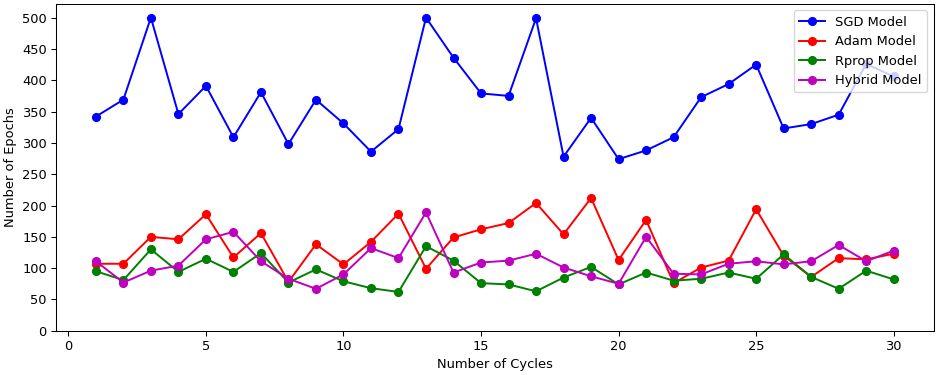

In [72]:
fig7, ax7 = plt.subplots(figsize = (10,4),layout = 'constrained')

ax7.plot(np.arange(1,31,1),num_epoch_comp1,color='b',marker = 'o',label = "SGD Model")
ax7.plot(np.arange(1,31,1),num_epoch_comp2,color='r',marker = 'o',label = "Adam Model")
ax7.plot(np.arange(1,31,1),num_epoch_comp3,color='g',marker = 'o',label = "Rprop Model")
ax7.plot(np.arange(1,31,1),num_epoch_comp4,color='m',marker = 'o',label = "Hybrid Model")

# ax7.fill_between(np.arange(1,31,1),num_epoch_comp1 - epoch_std1,num_epoch_comp1 + epoch_std1,alpha = 0.2)
# ax7.fill_between(np.arange(1,31,1),num_epoch_comp2 - epoch_std1,num_epoch_comp2 + epoch_std2,alpha = 0.2)
# ax7.fill_between(np.arange(1,31,1),num_epoch_comp3 - epoch_std1,num_epoch_comp3 + epoch_std3,alpha = 0.2)
# ax7.fill_between(np.arange(1,31,1),num_epoch_comp4 - epoch_std1,num_epoch_comp4 + epoch_std4,alpha = 0.2)


ax7.set_xlabel("Number of Cycles")
ax7.set_ylabel("Number of Epochs")
ax7.set_yticks(np.arange(0,550,50))

ax7.legend(loc = 'upper right')

In [73]:
plt.savefig("NumberEpochsComp",dpi = 200)

In [143]:
#1st cycle, 1st epoch, all weights



In [144]:
e = (0.425 * a) + (0.425 * b) + (0.15 * c) 

In [156]:

dnorm = d/torch.sqrt(sum(d**2))

In [196]:
ab = []
bc = []
ac = []
for u in range(0,111):
    
    a = []
    b = []
    c = []
    for v in range(0,12):
        
        a += list(results4[0]['SGDWeightUpdates'][u][v].ravel())
        b += list(results4[0]['AdamWeightUpdates'][u][v].ravel())
        c += list(results4[0]['RproprWeightUpdates'][u][v].ravel())
        
    a = torch.tensor(a)
    b = torch.tensor(b)
    c = torch.tensor(c)

    anorm = a/torch.sqrt(sum(a**2))
    bnorm = b/torch.sqrt(sum(b**2))
    cnorm = c/torch.sqrt(sum(c**2))

    ab.append(sum(anorm*bnorm))
    bc.append(sum(bnorm*cnorm))
    ac.append(sum(anorm*cnorm))

<IPython.core.display.Javascript object>


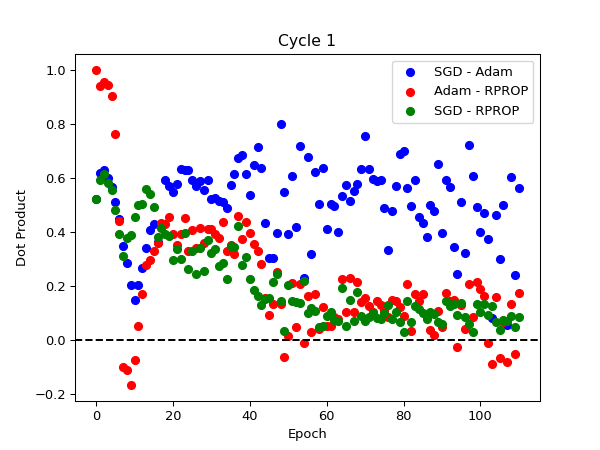

In [203]:
plt.figure()

plt.scatter(np.arange(0,111),ab,color='b',label = "SGD - Adam")
plt.scatter(np.arange(0,111),bc,color='r',label = "Adam - RPROP")
plt.scatter(np.arange(0,111),ac,color='g',label = "SGD - RPROP")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Dot Product")
plt.title("Cycle 1")

plt.axhline(0,linestyle = '--',color='k')

In [204]:
plt.savefig("Weight_correlation",dpi =200)

In [205]:
0.041*(1 - 0.9)/(np.sqrt(1 - 0.999))

0.1296533840669035

In [206]:
avg_test_loss4

tensor(0.0197)

In [209]:
std_test_loss4

tensor(0.0054)